In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import tempmatch as tm
import obspy

import helpers

In [2]:
day138 = helpers.import_raw_data_for_single_day('138', '2019', 'b')


In [3]:
day138.decimate(factor=10)
day138_original = day138.copy()


In [4]:
# https://docs.obspy.org/packages/autogen/obspy.signal.filter.bandpass.html#obspy.signal.filter.bandpass
day138.filter(freqmin=5, freqmax=10, corners=4, type='bandpass')

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.017000Z | 100.0 Hz, 8639812 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.840000Z | 100.0 Hz, 8639931 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.129000Z | 100.0 Hz, 8640045 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.081000Z | 100.0 Hz, 8639875 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 100.0 Hz, 8639833 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.372000Z | 100.0 Hz, 8639919 samples

In [5]:
day138.detrend('demean')

6 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.017000Z | 100.0 Hz, 8639812 samples
7F.B00.02.GDH | 2019-05-18T00:00:01.540000Z - 2019-05-19T00:00:00.840000Z | 100.0 Hz, 8639931 samples
7F.B00.03.GDH | 2019-05-18T00:00:02.689000Z - 2019-05-19T00:00:03.129000Z | 100.0 Hz, 8640045 samples
7F.B00.04.GDH | 2019-05-18T00:00:02.341000Z - 2019-05-19T00:00:01.081000Z | 100.0 Hz, 8639875 samples
7F.B00.05.GDH | 2019-05-18T00:00:02.971000Z - 2019-05-19T00:00:01.291000Z | 100.0 Hz, 8639833 samples
7F.B00.06.GDH | 2019-05-18T00:00:02.192000Z - 2019-05-19T00:00:01.372000Z | 100.0 Hz, 8639919 samples

In [6]:
def square_data_in_stream(stream):
    for s in stream:
        s.data = s.data**2
    print('data has been squared')

square_data_in_stream(day138)

data has been squared


In [7]:
day138_original.max()

[94106.193090731191,
 78071.848625352693,
 99722.419170189678,
 106111.83940230079,
 90385.11897945276,
 75998.098937292234]

In [8]:
day138.max()

[758482937.1023041,
 561688740.80828822,
 708674864.22719336,
 1047370075.0101168,
 1396325626.7818725,
 1370758926.4263473]

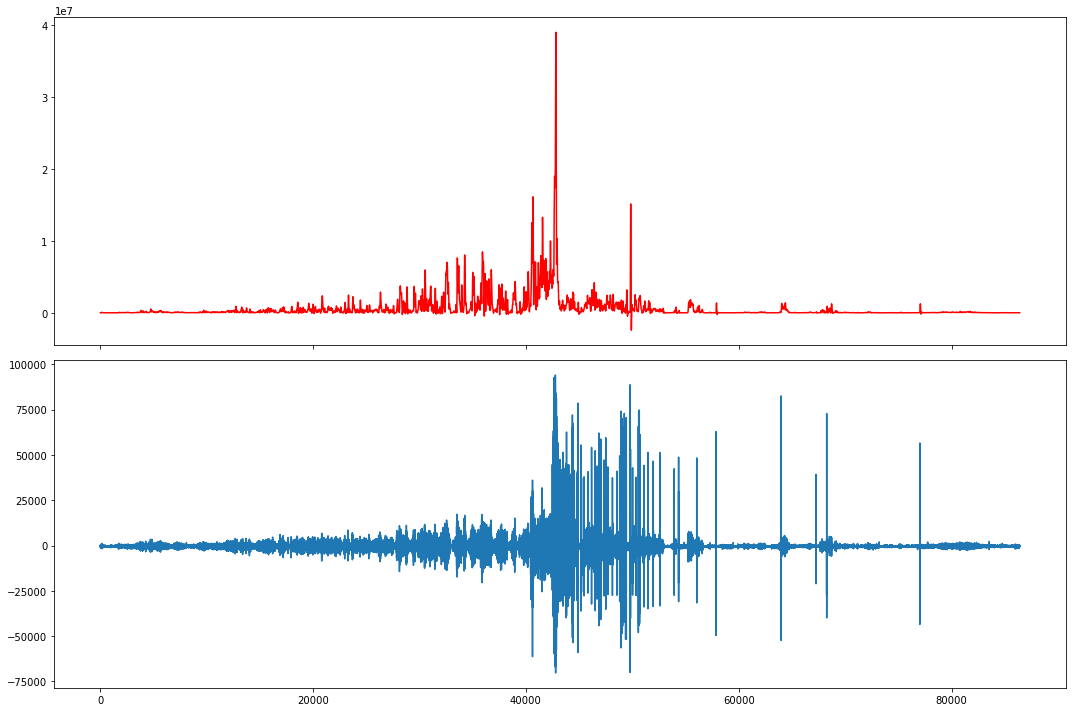

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

data = day138.copy()
data.filter(type='lowpass', freq=0.01)
# for n,d in enumerate(data):
#     data[n].data = d.data[::100]

ax[0].plot(data[0].times(), data[0].data, color='red')
ax[1].plot(day138_original[0].times(), day138_original[0].data)
# ax.set_yscale('log')
# ax[0].set_xlim(20000, 40000)
# ax[0].set_ylim(1e0, 2e8)
# ax[1].set_ylim(-5e4, 5e4)
fig.tight_layout()

In [10]:
data[0].data[::100].shape

(86399,)

In [11]:
data[0].data.shape

(8639812,)

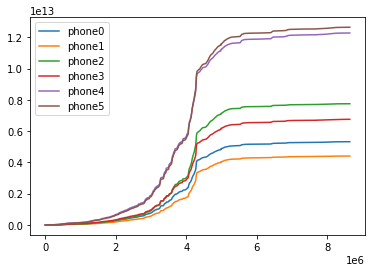

In [12]:
for n in [0, 1, 2, 3, 4, 5]:
    plt.plot(data[n].data.cumsum(), label='phone{n}'.format(n=n))
# plt.plot(data[5].data.cumsum())
plt.legend()

In [90]:
import itertools

hydrophones = [0, 1, 2, 3, 4, 5]
hydrophone_pairs = [h for h in itertools.combinations(hydrophones, 2)]
hydrophone_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

In [88]:
cc_df = pd.DataFrame()

day138_windows = day138.slide(window_length=5*60.0, step=5*60.0,)

n = -1
for window in day138_windows:
    # print(window[0].stats)
    # print(window)
    n+=1
    for pair in hydrophone_pairs:
        h1, h2 = pair
        cc = obspy.signal.cross_correlation.correlate(a=window[h1]
                                                      , b=window[h2]
                                                      , shift=100*5
                                                      , demean=True
                                                      , normalize=True)

        window_df = pd.DataFrame(
            {
                'window_index':[n,]
                ,'h1_index':(h1,) # first hydrophone index used for cross correlation
                , 'h2_index':(h2,) # second hydrophone index used for cross correlation
                ,'cross_correlation_max':[cc.max(),]
                ,'cross_correlation_index':[np.argmax(cc),]
                ,'sample_rate':[window[0].stats.sampling_rate,]
                ,'window_starttime':[window[0].stats.starttime,]
                ,'window_endtime':[window[0].stats.endtime]
                ,'lagtime_seconds':((np.argmax(cc)-500)*1/100.,)
            }
        )
        cc_df = pd.concat([cc_df, window_df])
cc_df

,window_index,h1_index,h2_index,cross_correlation_max,cross_correlation_index,sample_rate,window_starttime,window_endtime,lagtime_seconds
0,0,0,1,0.580777,469,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,-0.31
0,0,0,2,0.457035,543,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,0.43
0,0,0,3,0.736858,471,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,-0.29
0,0,0,4,0.790308,528,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,0.28
0,0,0,5,0.781556,433,100.0,2019-05-18T00:00:02.907000Z,2019-05-18T00:05:01.537000Z,-0.67
...,...,...,...,...,...,...,...,...,...
0,287,2,4,0.267384,464,100.0,2019-05-18T23:55:01.537000Z,2019-05-19T00:00:01.017000Z,-0.36
0,287,2,5,0.295266,461,100.0,2019-05-18T23:55:01.537000Z,2019-05-19T00:00:01.017000Z,-0.39
0,287,3,4,0.510710,486,100.0,2019-05-18T23:55:01.537000Z,2019-05-19T00:00:01.017000Z,-0.14
0,287,3,5,0.641038,508,100.0,2019-05-18T23:55:01.537000Z,2019-05-19T00:00:01.017000Z,0.08


<AxesSubplot:>

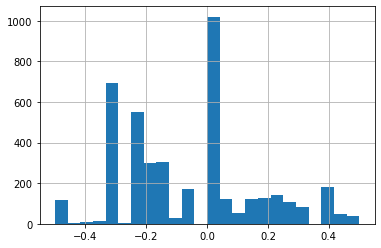

In [89]:
cc_df.lagtime_seconds.hist(bins=np.linspace(-0.5, 0.5, 25))

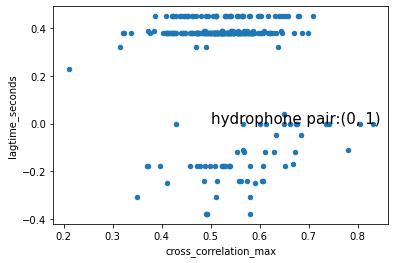

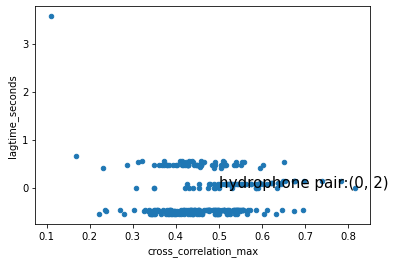

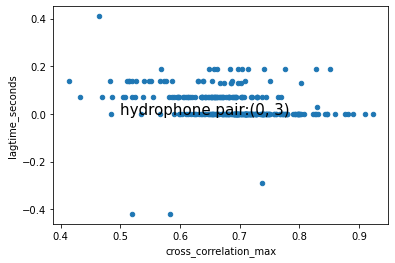

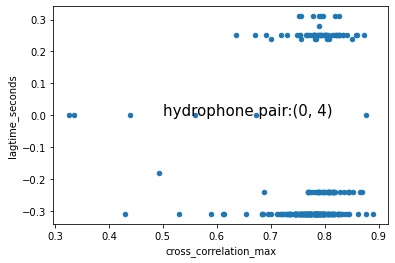

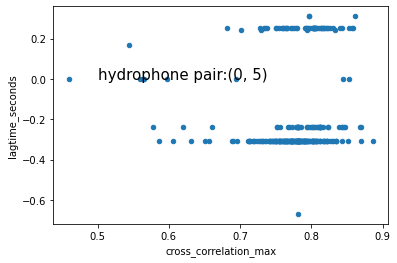

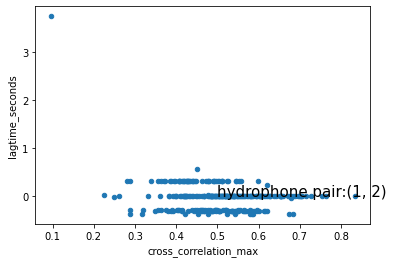

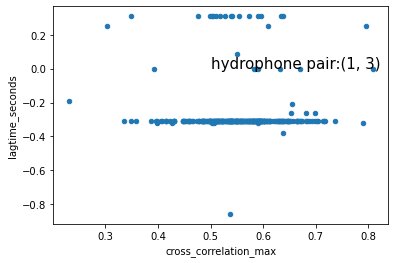

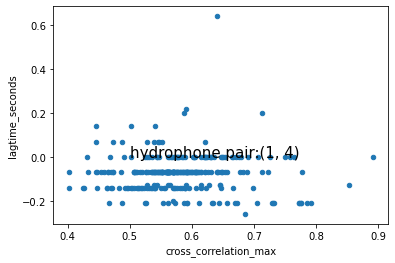

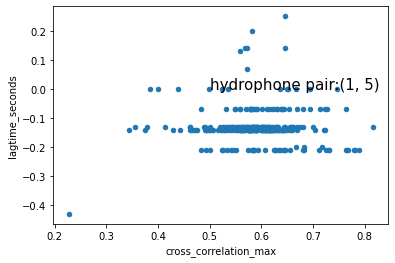

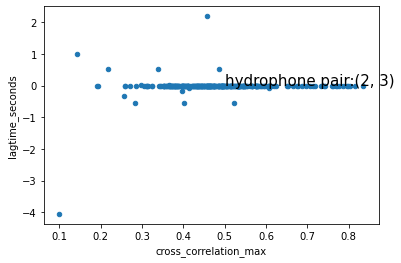

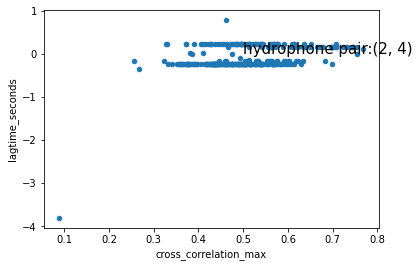

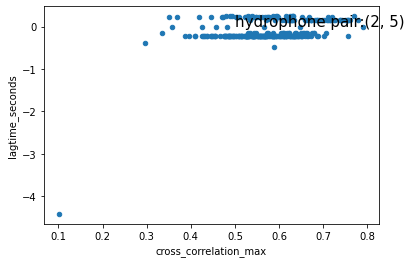

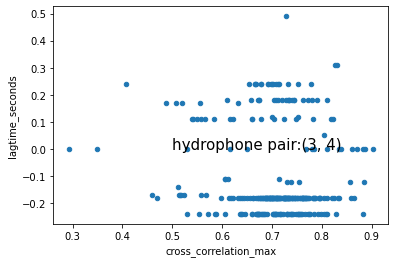

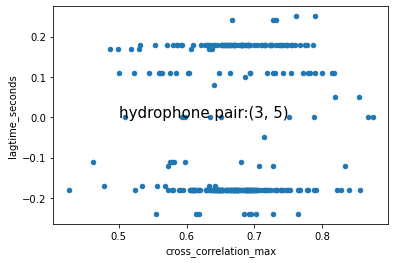

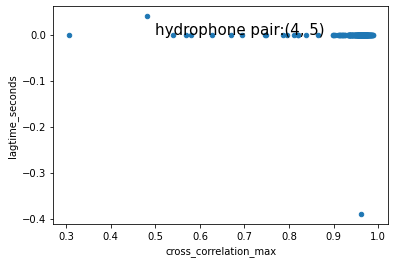

In [122]:
for pair in hydrophone_pairs:
    h1, h2 = pair
    ax = cc_df[(cc_df.h1_index==h1) & (cc_df.h2_index==h2)].plot.scatter(x='cross_correlation_max', y='lagtime_seconds')
    ax.text(s='hydrophone pair:'+str(pair), x=0.5, y=0, fontsize=15)

In [51]:
29864/100

298.64

In [53]:
469 10s of ms


0.01

In [62]:
# filelocs = !ls /media/sda/data/robdata/tremors/*.mseed

In [65]:
# stream = obspy.read(filelocs[0])
# for f in filelocs[1:]:
#     stream = stream + obspy.read(f)

In [ ]:
# stream.merge()

In [ ]:
# stream